In [119]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

# Classification models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

In [120]:
df = pd.read_csv('sampleclassification.csv')
df

,Unnamed: 0,Customer_ID,Age,Annual_Income,Gender,City,Education,Spending_Score,Loan_Default
0,0,1,36,62662,Female,C,Bachelor,58,0
1,1,2,37,73067,Male,B,Master,71,0
2,2,3,22,32454,Female,A,Diploma,59,0
3,3,4,53,118148,Male,B,Master,72,0
4,4,5,41,70965,Male,A,Master,96,0
...,...,...,...,...,...,...,...,...,...
95,95,96,22,49711,Female,A,Diploma,32,1
96,96,97,47,94584,Male,B,Master,79,0
97,97,98,25,25569,Male,B,ITE,22,1
98,98,99,27,27733,Female,B,ITE,43,1


In [121]:
df.drop(columns=['Customer_ID', 'Unnamed: 0'], axis=1, inplace=True)

In [122]:
target_col = 'Loan_Default'

X = df.drop(
    columns = [target_col],
    axis = 1
)

y = df[target_col] 

In [123]:
X

,Age,Annual_Income,Gender,City,Education,Spending_Score
0,36,62662,Female,C,Bachelor,58
1,37,73067,Male,B,Master,71
2,22,32454,Female,A,Diploma,59
3,53,118148,Male,B,Master,72
4,41,70965,Male,A,Master,96
...,...,...,...,...,...,...
95,22,49711,Female,A,Diploma,32
96,47,94584,Male,B,Master,79
97,25,25569,Male,B,ITE,22
98,27,27733,Female,B,ITE,43


In [124]:
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()

# Must define order for ordinal features
education_order = ['Secondary School', 'ITE', 'Diploma', 'Bachelor', 'Master']
ordinal_features = ['Education']
categorical_features = [col for col in categorical_features if col not in ordinal_features]

print("Numeric features:", numeric_features)
print("Categorical features:", categorical_features)
print("Ordinal features:", ordinal_features)

Numeric features: ['Age', 'Annual_Income', 'Spending_Score']
Categorical features: ['Gender', 'City']
Ordinal features: ['Education']


In [125]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', drop = 'first'), categorical_features),
        ('ord', OrdinalEncoder(categories=[education_order]), ordinal_features)
    ])

In [126]:
models = {
    'LogisticRegression': LogisticRegression(max_iter=1000),
    'DecisionTree': DecisionTreeClassifier(random_state=42),
    'RandomForest': RandomForestClassifier(n_estimators=100, random_state=42),
    'GradientBoosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'XGBoost': XGBClassifier(n_estimators=100, random_state=42, use_label_encoder=False, eval_metric='logloss')
}


In [127]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [128]:
"""

def train_and_evaluate(model_name):
    model = models[model_name]
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred)
    print(f"Model: {model_name}")
    print(f"Accuracy: {acc:.2f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("\n")

    """


'\n\ndef train_and_evaluate(model_name):\n    model = models[model_name]\n    pipeline = Pipeline([\n        (\'preprocessor\', preprocessor),\n        (\'classifier\', model)\n    ])\n    \n    pipeline.fit(X_train, y_train)\n    y_pred = pipeline.predict(X_test)\n    \n    acc = accuracy_score(y_test, y_pred)\n    print(f"Model: {model_name}")\n    print(f"Accuracy: {acc:.2f}")\n    print("Classification Report:")\n    print(classification_report(y_test, y_pred))\n    print("Confusion Matrix:")\n    print(confusion_matrix(y_test, y_pred))\n    print("\n")\n\n    '

In [129]:
def train_and_get_metrics(model_name):
    model = models[model_name]
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    
    pipeline.fit(X_train, y_train)
    
    # Predicted probabilities for AUC
    if hasattr(pipeline.named_steps['classifier'], "predict_proba"):
        y_prob = pipeline.predict_proba(X_test)[:,1]
    else:
        y_prob = pipeline.decision_function(X_test)
    
    y_pred = pipeline.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    clf_report = classification_report(y_test, y_pred, output_dict=True)
    cm = confusion_matrix(y_test, y_pred)
    
    # Return metrics as a dictionary
    metrics = {
        'Model': model_name,
        'Accuracy': acc,
        'AUC': auc,
        'Precision': clf_report['weighted avg']['precision'],
        'Recall': clf_report['weighted avg']['recall'],
        'F1': clf_report['weighted avg']['f1-score'],
        'Confusion_Matrix': cm
    }
    
    return metrics


In [130]:
results = []

for model_name in models.keys():
    metrics = train_and_get_metrics(model_name)
    results.append(metrics)

results_df = pd.DataFrame(results)
results_df


/opt/anaconda3/envs/anaconda-2025.06-py3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [06:55:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,Model,Accuracy,AUC,Precision,Recall,F1,Confusion_Matrix
0,LogisticRegression,0.95,1.0,0.954545,0.95,0.949875,"[[10, 0], [1, 9]]"
1,DecisionTree,1.00,1.0,1.000000,1.00,1.000000,"[[10, 0], [0, 10]]"
2,RandomForest,0.95,1.0,0.954545,0.95,0.949875,"[[10, 0], [1, 9]]"
3,GradientBoosting,1.00,1.0,1.000000,1.00,1.000000,"[[10, 0], [0, 10]]"
4,XGBoost,1.00,1.0,1.000000,1.00,1.000000,"[[10, 0], [0, 10]]"


In [133]:
for i, row in results_df.iterrows():
    print(f"Model: {row['Model']}")
    print(row['Confusion_Matrix'])

Model: LogisticRegression
[[10  0]
 [ 1  9]]
Model: DecisionTree
[[10  0]
 [ 0 10]]
Model: RandomForest
[[10  0]
 [ 1  9]]
Model: GradientBoosting
[[10  0]
 [ 0 10]]
Model: XGBoost
[[10  0]
 [ 0 10]]


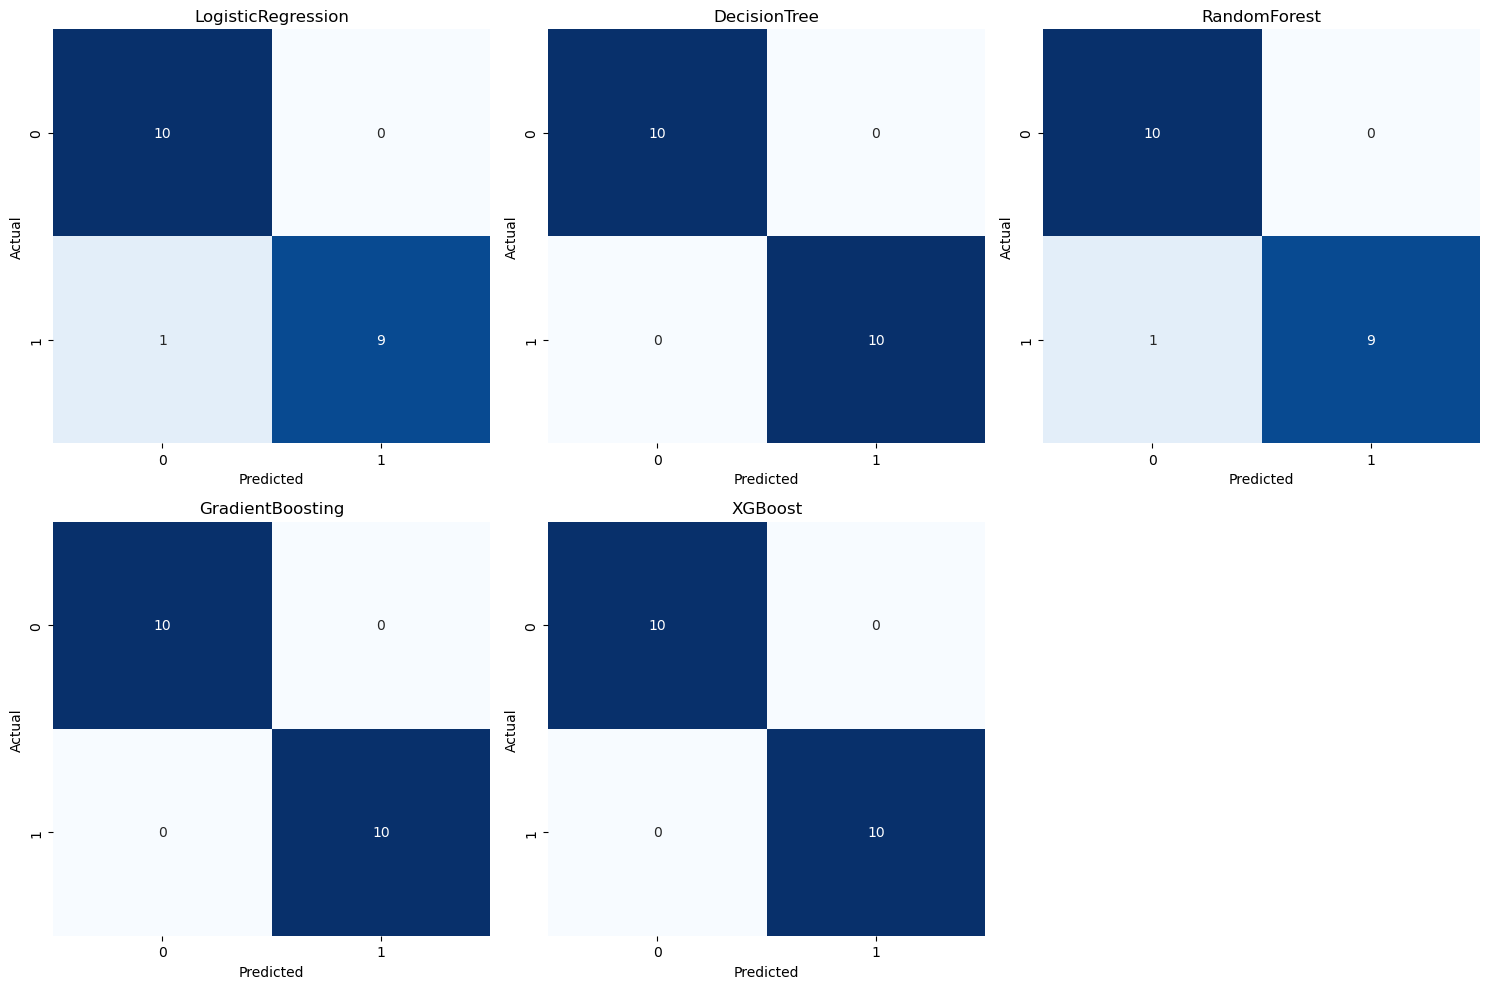

In [134]:
fig, axes = plt.subplots(2, 3, figsize=(15,10))
axes = axes.flatten()

for i, row in results_df.iterrows():
    cm = row['Confusion_Matrix']
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[i])
    axes[i].set_title(row['Model'])
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('Actual')

# Hide empty subplots if models < 6
for j in range(i+1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()